In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))


from astropy.io import fits
import dill as pickle
from emcee import EnsembleSampler
import numpy as np
import os
import sys

pwd = os.getcwd()
little_things_root_dir = os.path.dirname(pwd)
sys.path.append(little_things_root_dir)

from little_things_lib.galaxy import Galaxy
from little_things_lib.nfw_mcmc_fitter import (
    EmceeParameters,
    get_mcmc_start_position, 
    generate_nwalkers_start_points, 
    lnprob)
from little_things_lib.plotting import plot_posterior_distributions, plot_walker_paths

RAD_PER_ARCSEC = np.pi / (60*60*180)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Enter parameters for galaxy in cell below

In [3]:
galaxy_name = 'DDO154'

DEG_PER_PIXEL = 4.17e-4
DISTANCE = 3700 # kpc

# can leave these as any number for now, not used
LUMINOSITY = 1e8  # solar luminositiy
HI_MASS = 1e8  # solar masses

In [4]:
mcmc_params = EmceeParameters(
    ndim=3,
    nwalkers=10, 
    nburn=0,
    niter=200,
    nthin=0,
    nthreads=4
)

In [5]:
"""
Expect the data to be provided in following naming convention in 'data' directory:

2D observed velocity field FITS file: <galaxy_name>_1mom.fits
Bbarolo fit parameters text file: <galaxy_name>_ring_parameters.txt
Stellar velocity curve: <galaxy_name>_stellar_velocities.txt
Gas velocity_curve: <galaxy_name>_gas_velocities.txt

"""


data_dir = os.path.join(little_things_root_dir, 'data')

observed_2d_vel_field_fits_file = os.path.join(data_dir, f'{galaxy_name}_1mom.fits')
ring_parameters_file = os.path.join(data_dir, f'{galaxy_name}_ring_parameters.txt')

stellar_velocities_file = os.path.join(data_dir, f'{galaxy_name}_stellar_velocities.txt')
gas_velocities_file = os.path.join(data_dir, f'{galaxy_name}_gas_velocities.txt')


In [6]:
radii_arcsec, test_rotation_curve, inclinations, position_angles, x_centers, y_centers , v_systemics = \
    np.loadtxt(ring_parameters_file, usecols=(1,2,4,5,-4,-3,-2)).T

radii_kpc = radii_arcsec * RAD_PER_ARCSEC * DISTANCE
avg_inclination = np.mean(inclinations)
avg_position_angle = np.mean(position_angles)
avg_x_center = 255
avg_y_center = 255
x_centers = np.array([avg_x_center for i in range(len(inclinations))])
y_centers = np.array([avg_y_center for i in range(len(inclinations))])
v_systemic = np.mean(v_systemics)

observed_2d_vel_field = fits.open(observed_2d_vel_field_fits_file)[0].data

stellar_radii, stellar_vel = np.loadtxt(stellar_velocities_file, unpack=True, usecols = (0,1))
gas_radii, gas_vel = np.loadtxt(gas_velocities_file, unpack=True, usecols = (0,1))

In [7]:
#stellar_radii = np.linspace(0, 4500, 41)
#gas_radii = np.linspace(0, 4500, 41)
#stellar_vel = np.linspace(0, 1, 41)
#gas_vel = np.linspace(0, 1, 41)

In [8]:
galaxy = Galaxy(
    distance_to_galaxy=DISTANCE,  # [kpc] Look this up for the galaxy 
    deg_per_pixel=DEG_PER_PIXEL ,  # 'CRDELT1' and 'CRDELT2' in the FITS file header (use absolute value)
    galaxy_name=galaxy_name,
    vlos_2d_data=observed_2d_vel_field,
    output_dir='output',
    luminosity=LUMINOSITY,
    HI_mass=HI_MASS)

tilted_ring_params = {
    'v_systemic': v_systemic,
    'radii': radii_kpc,   
    'inclination': inclinations,
    'position_angle': position_angles,
    'x_pix_center': x_centers,
    'y_pix_center': y_centers
}

galaxy.set_tilted_ring_parameters(**tilted_ring_params)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='stellar',
    rotation_curve_radii=stellar_radii,
    rotation_curve_velocities=stellar_vel)

galaxy.interpolate_baryonic_rotation_curve(
    baryon_type='gas',
    rotation_curve_radii=gas_radii,
    rotation_curve_velocities=gas_vel)

# initialize MCMC start position and bounds
galaxy.set_nfw_prior_bounds(
    rhos_bounds=(1e6, 1e10),   # msun / kpc^3
    rs_bounds=(0.1, 200),  # kpc
    ml_bounds=(0.1, 2),
  
)

In [9]:
v=galaxy.create_2d_velocity_field(
    tilted_ring_params['radii'], 
    v_rot = test_rotation_curve  
)

In [10]:
galaxy.radii/galaxy.kpc_per_pixel

array([  1.6653344 ,   4.9960032 ,   8.326672  ,  11.65734079,
        14.98800959,  18.31867839,  21.64934719,  24.98001599,
        28.31068479,  31.64135358,  34.97202238,  38.30269118,
        41.63335998,  44.96402878,  48.29469758,  51.62536637,
        54.95603517,  58.28670397,  61.61737277,  64.94804157,
        68.27871037,  71.60937916,  74.94004796,  78.27071676,
        81.60138556,  84.93205436,  88.26272315,  91.59339195,
        94.92406075,  98.25472955, 101.58539835, 104.91606715,
       108.24673594, 111.57740474, 114.90807354, 118.23874234,
       121.56941114, 124.90007994, 128.23074873, 131.56141753,
       134.89208633, 138.22275513, 141.55342393, 144.88409273,
       148.21476152, 151.54543032, 154.87609912, 158.20676792,
       161.53743672, 164.86810552, 168.19877431, 171.52944311,
       174.86011191, 178.19078071, 181.52144951, 184.85211831,
       188.1827871 , 191.5134559 , 194.8441247 , 198.1747935 ,
       201.5054623 , 204.8361311 , 208.16679989, 211.49

In [11]:
# This will print warnings if the start points go outside prior bounds

start_point, start_point_radii = get_mcmc_start_position(galaxy)
start_pos = generate_nwalkers_start_points(galaxy, mcmc_params.nwalkers, start_point, start_point_radii)

In [12]:
sampler = EnsembleSampler(
    mcmc_params.nwalkers,
    mcmc_params.ndim, 
    lnprob, 
    args=[galaxy], 
    threads=mcmc_params.nthreads)

# this will break up the fitting procedure into smaller chunks of size batch_size and save progress

batch_size = 20
mcmc_output = []
for batch in range(mcmc_params.niter // batch_size):
    if batch== 0:
        batch_start = start_pos 
    else:
        batch_start = None
        sampler.pool = temp_pool
    mcmc_output += sampler.run_mcmc(batch_start, batch_size)
    temp_pool = sampler.pool
    del sampler.pool
    with open('sampler.pkl', 'wb') as f:
        pickle.dump(sampler, f)
    with open('mcmc_output.pkl', 'wb') as f:
        pickle.dump(mcmc_output, f)
    print(f"Done with steps {batch*batch_size} - {(batch+1)*batch_size} out of {mcmc_params.niter}")


Done with steps 0 - 20 out of 200
Done with steps 20 - 40 out of 200
Done with steps 40 - 60 out of 200
Done with steps 60 - 80 out of 200
Done with steps 80 - 100 out of 200
Done with steps 100 - 120 out of 200
Done with steps 120 - 140 out of 200
Done with steps 140 - 160 out of 200
Done with steps 160 - 180 out of 200
Done with steps 180 - 200 out of 200


In [13]:
# example of how to load the pickled objects
with open('sampler.pkl', 'rb') as f:
    sampler = pickle.load(f)
with open('mcmc_output.pkl', 'rb') as f:
    mcmc_output = pickle.load(f)

#### Plot the posterior distributions and walker paths

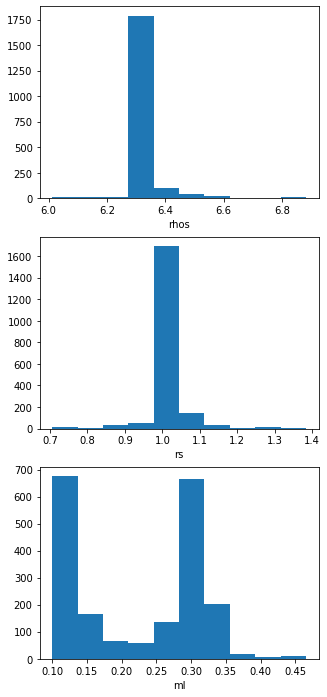

rhos: 6.334304915153505 +/- 0.0632353813348915
rs: 1.0347484088607402 +/- 0.04859245506320179
ml: 0.22130959732231212 +/- 0.09373253949985004


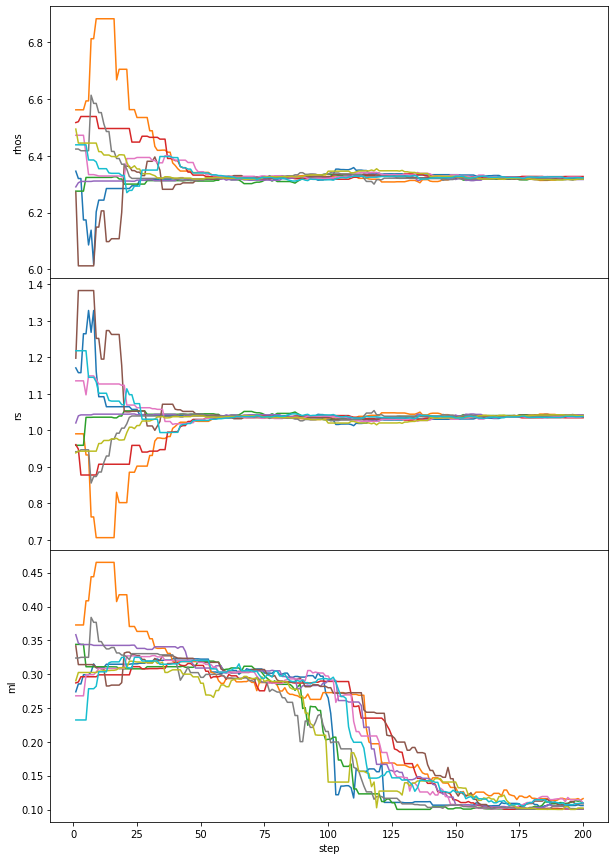

In [14]:
plot_posterior_distributions(sampler, labels=['rhos', 'rs', 'ml'])

plot_walker_paths(
    sampler,
    mcmc_params,
    labels=['rhos', 'rs', 'ml'])

def get_fit_stats(sampler, labels=["rhos", "rs", "ml"]):
    for i, label in enumerate(labels):
        chain = sampler.chain[:, :, i].flatten()
        print(f"{label}: {np.mean(chain)} +/- {np.std(chain)}")
        
get_fit_stats(sampler)

#### Compare observed 2d velocity field with one generated during fitting process

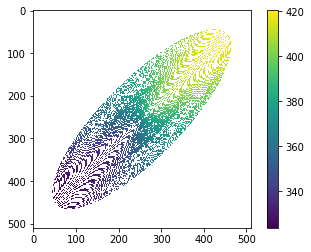

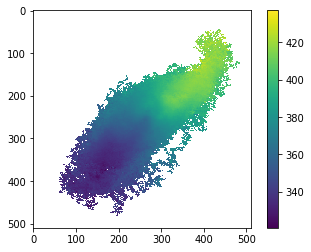

In [15]:
example_2d_field = mcmc_output[-1][9][-1]
plt.imshow(example_2d_field)
plt.colorbar()
plt.show()

plt.imshow(galaxy.vlos_2d_data)
plt.colorbar()
plt.show()


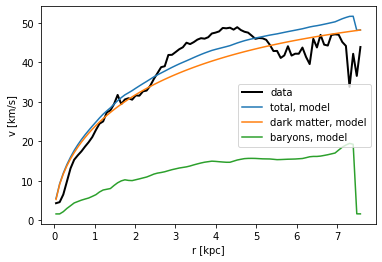

In [16]:
blobs = np.reshape(sampler.blobs, (mcmc_params.niter * mcmc_params.nwalkers,10))
v_dm = np.mean( blobs[:, 4])
v_baryon = np.mean( blobs[:, 5])
v_tot = np.mean( blobs[:, 7])

plt.plot(radii_kpc, test_rotation_curve, linewidth=2., label="data", color="black")

plt.plot(galaxy.radii, v_tot, label="total, model")
plt.plot(galaxy.radii, v_dm, label="dark matter, model")
plt.plot(galaxy.radii, v_baryon, label="baryons, model")
plt.xlabel("r [kpc]")
plt.ylabel("v [km/s]")
plt.legend()